# Avocado Average Price Prediction

#### Content
1. [Introduction: The Problem](#intro)
2. [Data](#data)
3. [Exploratory Data Analysis](#eda)
4. [Preprocessing & Analysis](#analysis)
5. [Hyper Parameter Tuning & Model Saving](#hyperparam)

## Introduction: The Problem <a name='intro'></a>

Avocado, botanically, is a berry like fruit with a single large seed in the center. The fruit has a buttery texture when ripe and depending on the variety, it may have green, brown, purplish, or black skin when ripe, and may be pear-shaped, egg-shaped, or spherical. Commercially, the fruits are picked while immature, and ripened after harvesting.

This data for this analysis has been downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. The objective of this exercise is to develop an model which can predict the average price of Avocado.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

#import datetime

import warnings
warnings.filterwarnings('ignore')

## Data <a name = "data"></a>

In [2]:
avocadoDf = pd.read_csv('avocado.csv')
avocadoDf.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0.0,27-12-2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015.0,Albany
1,1.0,20-12-2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015.0,Albany
2,2.0,13-12-2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015.0,Albany
3,3.0,06-12-2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015.0,Albany
4,4.0,29-11-2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015.0,Albany


In [3]:
#Dropping the first column which is just the serial number
#Dropping year because its 2015 for all rows and Date because its not a time series analysis
avocadoDf.drop(['Unnamed: 0', 'year', 'Date'], axis = 1, inplace=True)

In [4]:
avocadoDf.shape

(16468, 11)

In [5]:
#Keeping only rows with entires which are the first 1517 rows. The rest of the rows are just empty rows with
#absolutely no data
avocadoDf = avocadoDf.iloc[0:1517, :]
avocadoDf.shape

(1517, 11)

The dataset contains 1517 rows and 11 columns. The columns are as follows:

1. Date - The date of the observation
2. AveragePrice - the average price of a single avocado
3. type - conventional or organic
4. year - the year
5. Region - the city or region of the observation
6. Total Volume - Total number of avocados sold
7. 4046 - Total number of avocados with PLU 4046 sold
8. 4225 - Total number of avocados with PLU 4225 sold
9. 4770 - Total number of avocados with PLU 4770 sold
10. Total Bags - No explanation provided 
11. Small Bags - No explanation provided	
12. Large Bags - No explanation provided	
13. XLarge Bags - No explanation provided

Our target column for this analysis is 'AveragePrice'

## Exploratory Data Analysis <a name='eda'></a>

###### Univariate Analysis

In [6]:
avocadoDf.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
region          0
dtype: int64

The data has no missing value.

In [7]:
 avocadoDf.dtypes

AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
region           object
dtype: object

All the columns in the dataset are of 'float64' except the column 'type' and 'region' which are of the type 'object'. The data types of the columns seems appropriate and does not need any further alteration.

In [8]:
#Making two list
#One containing names of numeric columns and the other containing categorical columns
categoricalCols = ['type', 'region']
numericCols = list(avocadoDf.drop(categoricalCols, axis = 1).columns[1::])

Categorical Column Univariate Analysis

In [9]:
for col in categoricalCols:
    print(f'\tColumn Name: {col}\n{avocadoDf[col].value_counts()}\n--------------------------\n')

	Column Name: type
conventional    1517
Name: type, dtype: int64
--------------------------

	Column Name: region
California             76
Albany                 67
BaltimoreWashington    65
Boise                  65
Boston                 62
Atlanta                54
PhoenixTucson          52
BuffaloRochester       51
Spokane                49
Columbus               47
NewYork                44
Jacksonville           41
Detroit                40
SouthCentral           39
SanDiego               38
West                   36
Tampa                  34
Louisville             34
Charlotte              31
Portland               30
Houston                29
NorthernNewEngland     29
WestTexNewMexico       27
TotalUS                25
Nashville              25
SouthCarolina          24
Denver                 24
GrandRapids            23
Chicago                23
Pittsburgh             22
Orlando                21
RichmondNorfolk        21
HarrisburgScranton     19
Syracuse               19
Mi

The column 'type' contains only one entry which is 'conventional'. The other categorical column contains more the 40 regions. These will require OneHotEncoding in order to be incorporated into the model. Since there is a huge number of categories for this column, OneHotEncoding will introduce a lot of columns. One way to tackle this is to perform CountHotEncoding where each category is replaced with the number of times it appears in the dataset. For example, for the column 'region', the category 'LosAngeles' appears 3 times. So, for each 'LosAngeles' appearing in the dataset, we will replace it with the number 3. While this technique ensures that the dimensionality of the dataset is intact, if there are multiple categories with the came count, they all will be replace with the same number and hence, there will be information loss. In case of this dataset we see that there are multiple categories which have the same count. Therefore, we will stick to OneHotEncoding for now.

Now we will visually see the count of each categorical columns using countplot.

<AxesSubplot:xlabel='type', ylabel='count'>

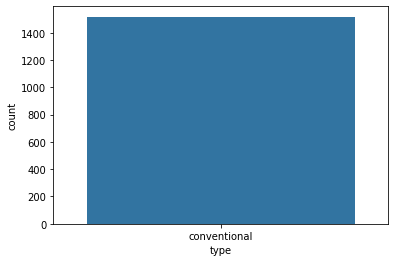

In [10]:
sns.countplot(avocadoDf['type'])

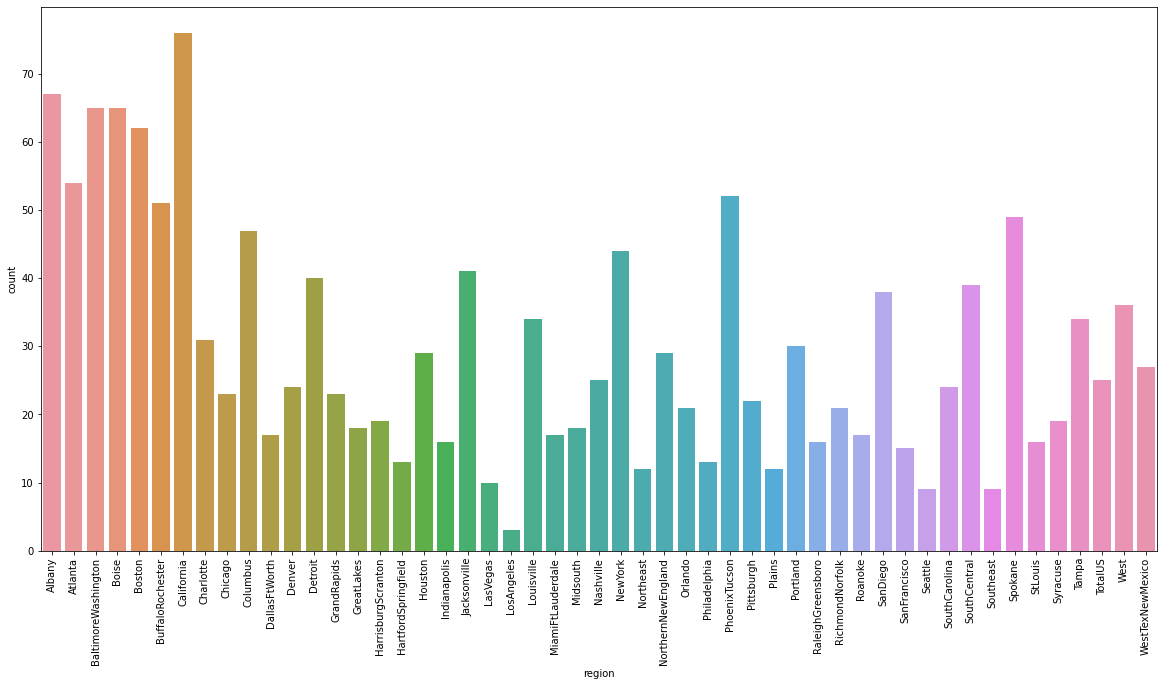

In [11]:
plt.figure(figsize=(20,10))
sns.countplot(avocadoDf['region'])
plt.xticks(rotation=90)
plt.show()

Numeric Col Univariate Analysis

In [12]:
#Using .describe to check summary statistics
avocadoDf[numericCols].describe()

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
count,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1517.000000
mean,1.601879e+06,6.464387e+05,6.114375e+05,5.040550e+04,2.935974e+05,2.487736e+05,4.264205e+04,2181.771074
std,4.433143e+06,1.947614e+06,1.672906e+06,1.377812e+05,7.579765e+05,6.474765e+05,1.182157e+05,7455.712144
min,3.875074e+04,4.677200e+02,1.783770e+03,0.000000e+00,3.311770e+03,3.311770e+03,0.000000e+00,0.000000
25%,1.474700e+05,2.040034e+04,4.147606e+04,9.112500e+02,3.620689e+04,2.972722e+04,5.407400e+02,0.000000
50%,4.027919e+05,8.175117e+04,1.186649e+05,7.688170e+03,7.397906e+04,6.237569e+04,5.044350e+03,0.000000
75%,9.819751e+05,3.775785e+05,4.851503e+05,2.916730e+04,1.576097e+05,1.461994e+05,2.926767e+04,401.480000
max,4.465546e+07,1.893304e+07,1.895648e+07,1.381516e+06,6.736304e+06,5.893642e+06,1.121076e+06,108072.790000


Since the above figures are in scientific notation it is hard to interpret. To makes sense of the figures, let us calcuate these stats manually as show below:

In [13]:
for col in numericCols:
    print(f'\tColumn Name: {col}\nMean: {avocadoDf[col].mean()}\nstd: {avocadoDf[col].std()}\nMin: {min(avocadoDf[col])}\n25%: {avocadoDf[col].quantile(0.25)}\n50%: {avocadoDf[col].quantile(0.5)}\n75%: {avocadoDf[col].quantile(0.75)}\nMax: {max(avocadoDf[col])}\n-------------------------------')

	Column Name: Total Volume
Mean: 1601879.06783784
std: 4433142.820746168
Min: 38750.74
25%: 147469.99
50%: 402791.86
75%: 981975.08
Max: 44655461.51
-------------------------------
	Column Name: 4046
Mean: 646438.6541133816
std: 1947613.5697421231
Min: 467.72
25%: 20400.34
50%: 81751.17
75%: 377578.48
Max: 18933038.04
-------------------------------
	Column Name: 4225
Mean: 611437.5025906389
std: 1672906.1646620075
Min: 1783.77
25%: 41476.06
50%: 118664.89
75%: 485150.34
Max: 18956479.74
-------------------------------
	Column Name: 4770
Mean: 50405.495398813444
std: 137781.24924178075
Min: 0.0
25%: 911.25
50%: 7688.17
75%: 29167.3
Max: 1381516.11
-------------------------------
	Column Name: Total Bags
Mean: 293597.41573500354
std: 757976.5313161744
Min: 3311.77
25%: 36206.89
50%: 73979.06
75%: 157609.68
Max: 6736304.04
-------------------------------
	Column Name: Small Bags
Mean: 248773.59528675006
std: 647476.520501519
Min: 3311.77
25%: 29727.22
50%: 62375.69
75%: 146199.35
Max: 58

From visual inspection of the summary statistics of each of the column, we can guess that there are many outliers in the dataset as the mean is greater then the median (50%) for all columns. We can further guess that the columns have right (positive) skewness as mean is greater the median.

Let us now visualise this as below:

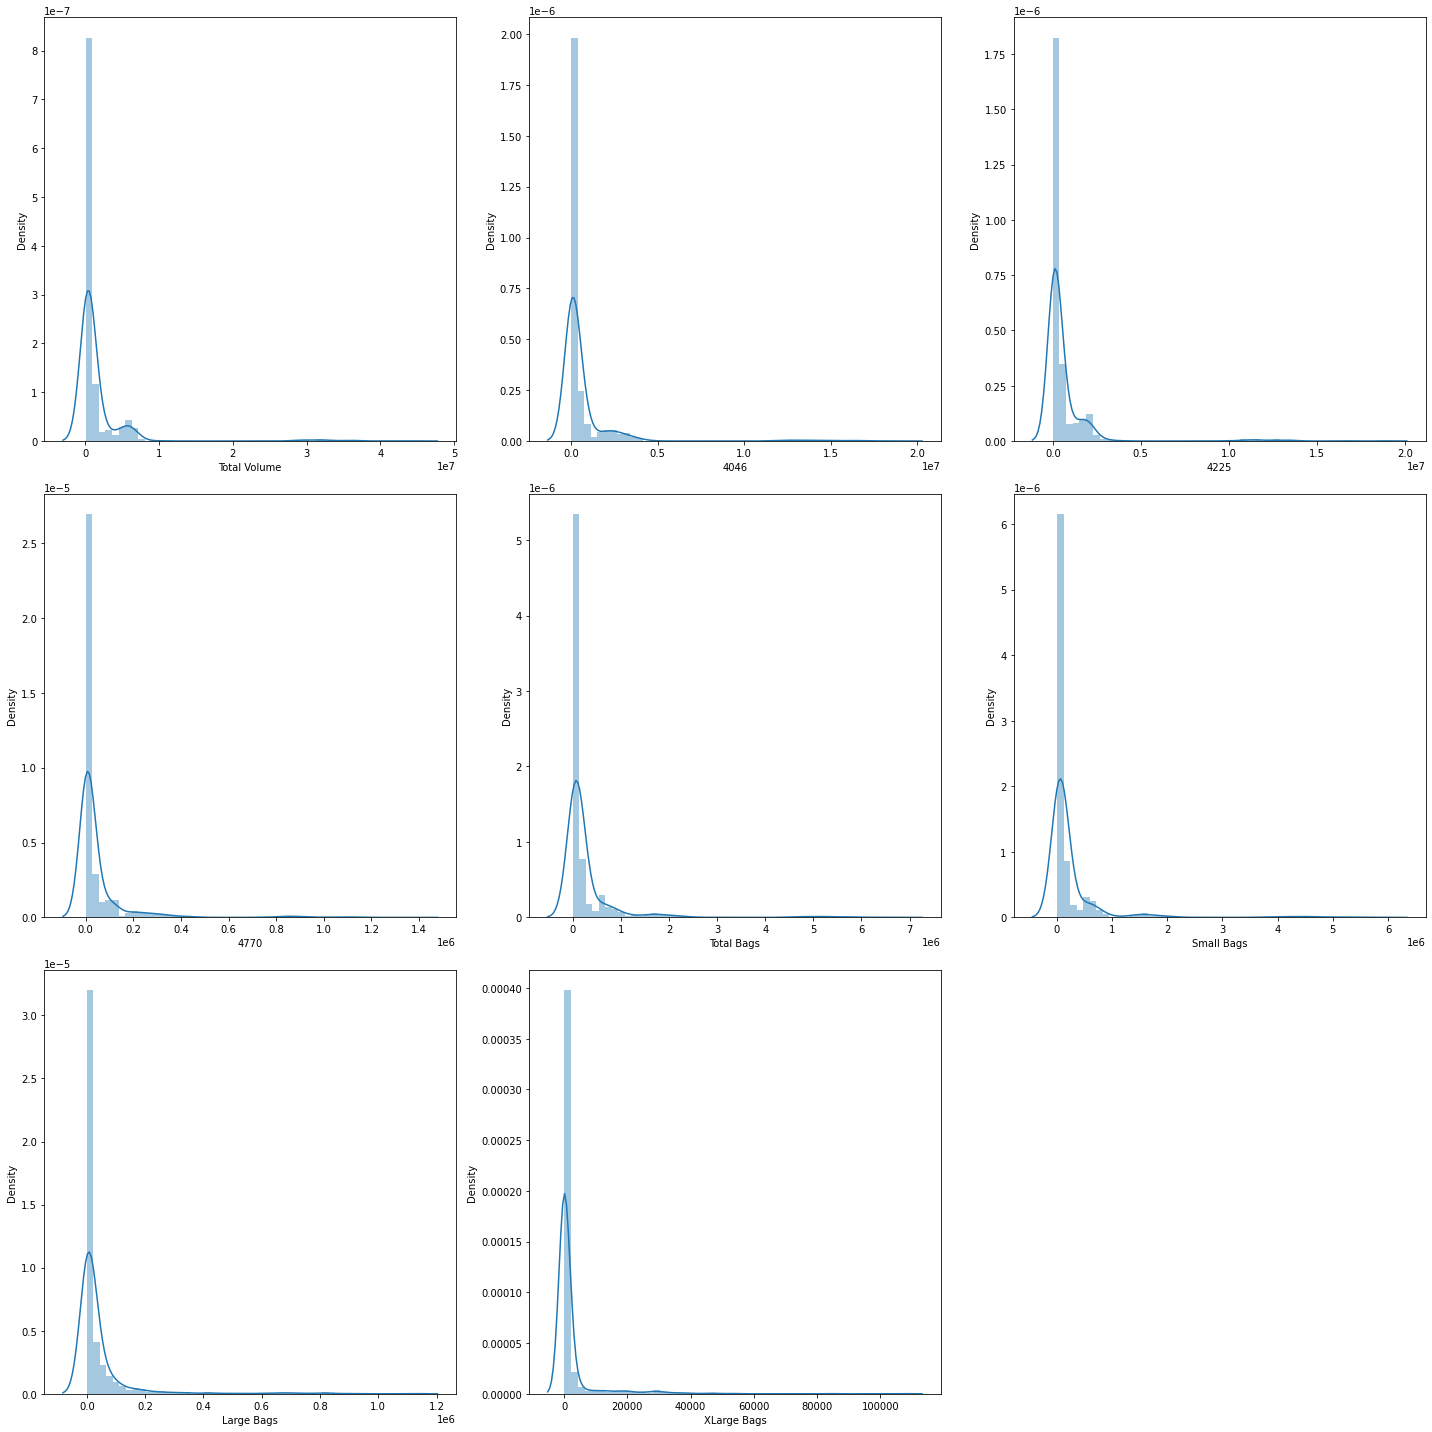

In [14]:
plt.figure(figsize=(20,20))

for index in range(len(numericCols)):
    plt.subplot(3,3,index+1)
    sns.distplot(avocadoDf[numericCols[index]])
    plt.tight_layout()

Each of the columns has a long tail in the left side. This is evidence of outlier presence. Further confirmation is obtained from the boxplot below where we notice a lot of dots outside which are outliers.

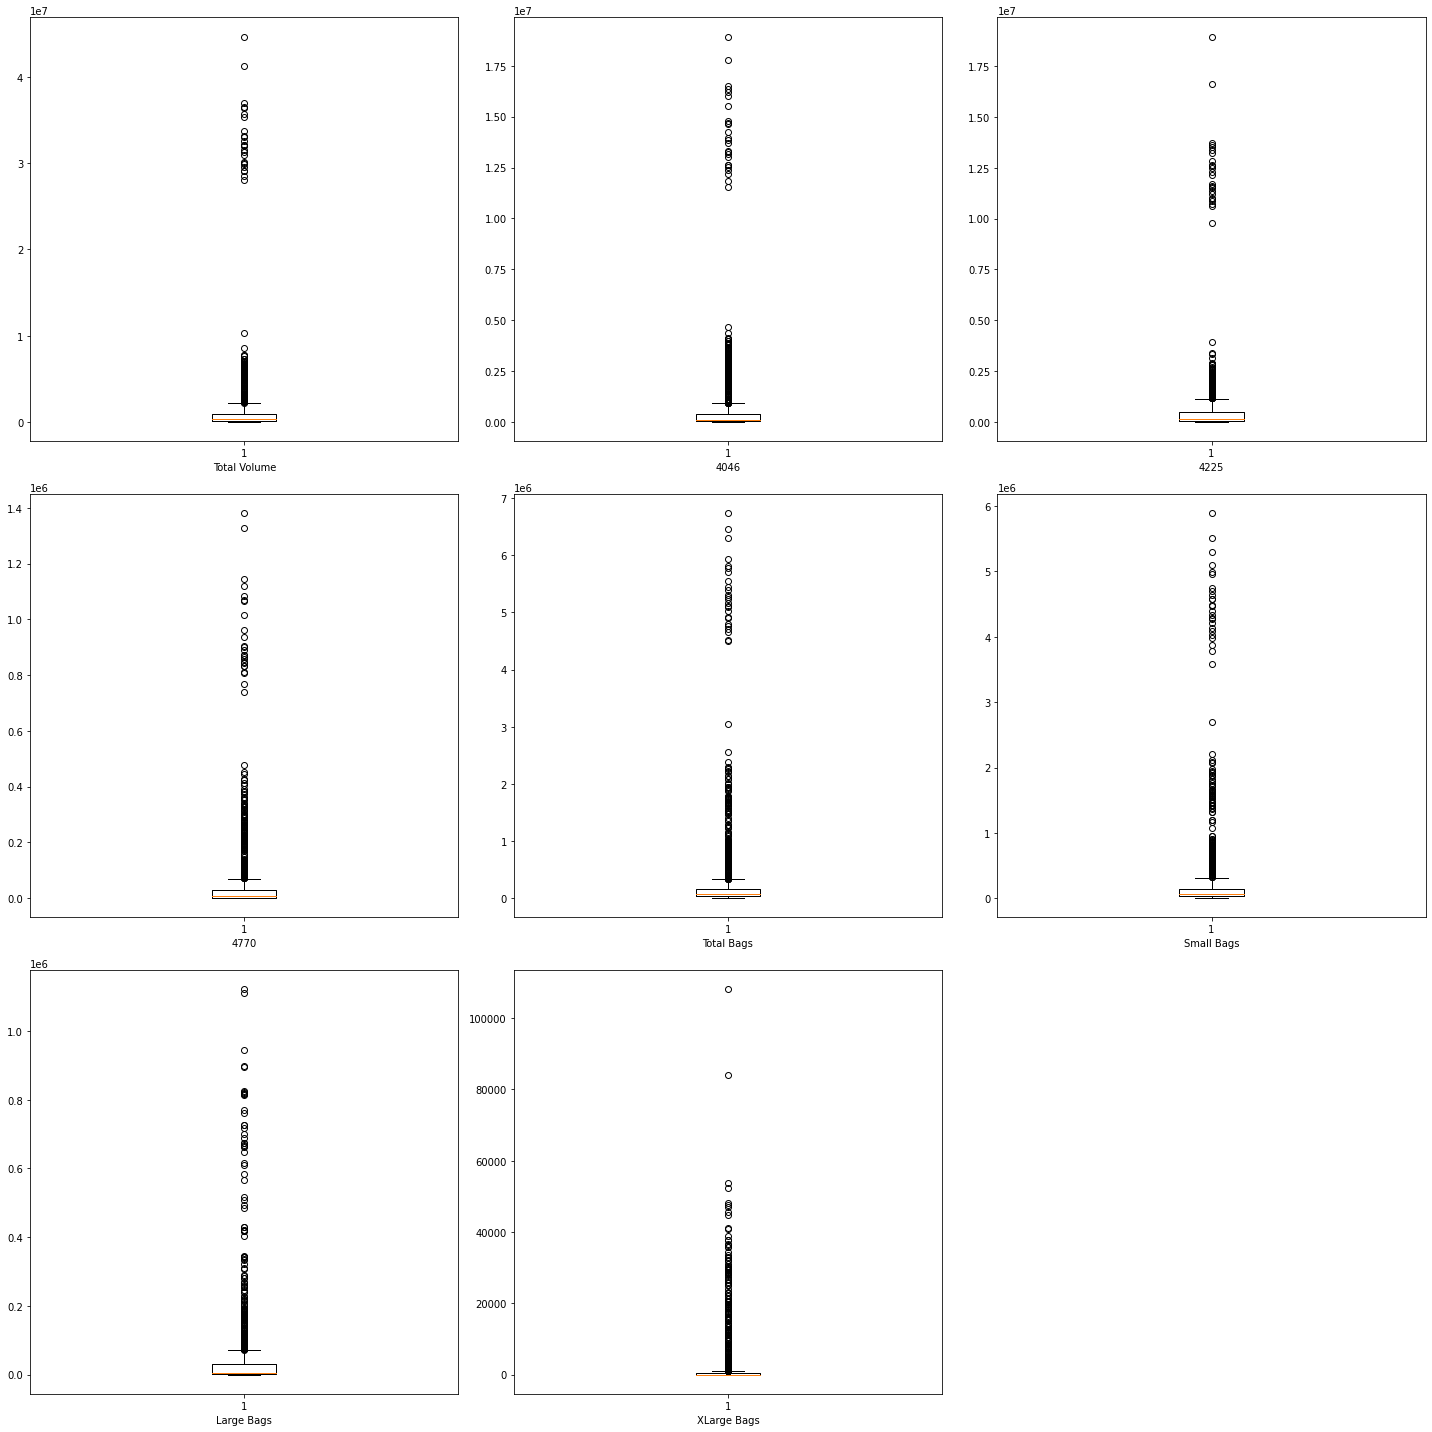

In [15]:
plt.figure(figsize=(20,20))

for index in range(len(numericCols)):
    plt.subplot(3,3,index+1)
    plt.boxplot(avocadoDf[numericCols[index]])
    plt.xlabel(numericCols[index])
    plt.tight_layout()

In [16]:
avocadoDf[numericCols].skew()

Total Volume    6.200138
4046            6.051830
4225            6.394926
4770            5.405164
Total Bags      5.366378
Small Bags      5.355185
Large Bags      5.144495
XLarge Bags     5.775077
dtype: float64

Since from the univariate analysis we noticed so much outliers and skewness, we will need to deal with them in order to improve model performance.

###### Bivariate analysis

Categorical With the Target Variable

<AxesSubplot:xlabel='region'>

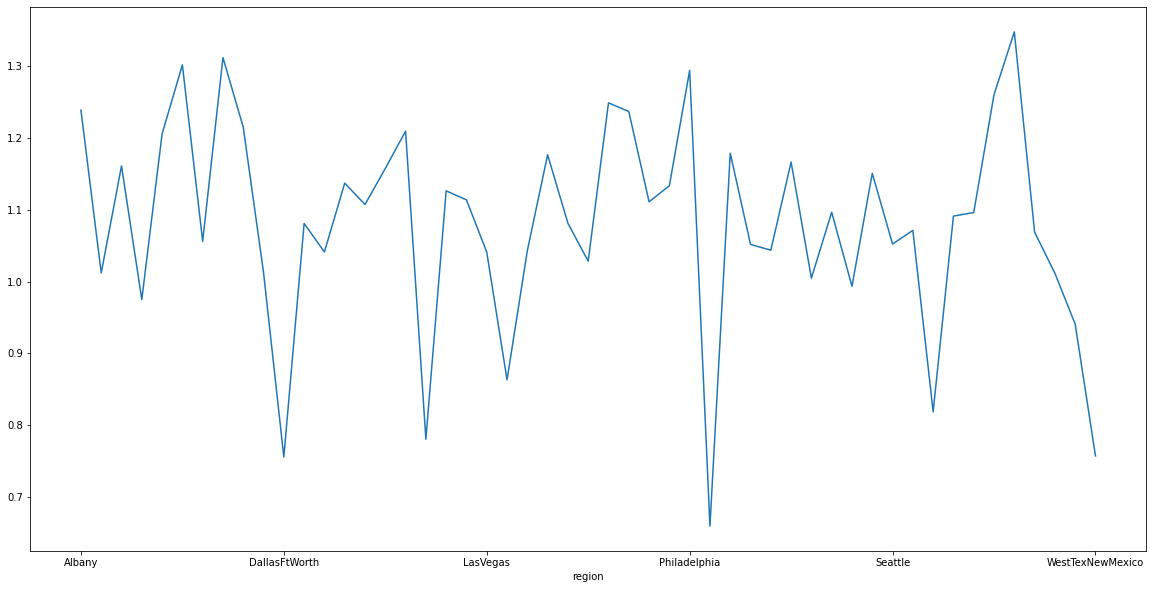

In [17]:
plt.figure(figsize=(20,10))
avocadoDf.groupby('region')['AveragePrice'].mean().plot()

From the above we see that the AveragePrice mean ranges between 1.35 on the higher side and 0.65 on the lower side.

<AxesSubplot:xlabel='region', ylabel='AveragePrice'>

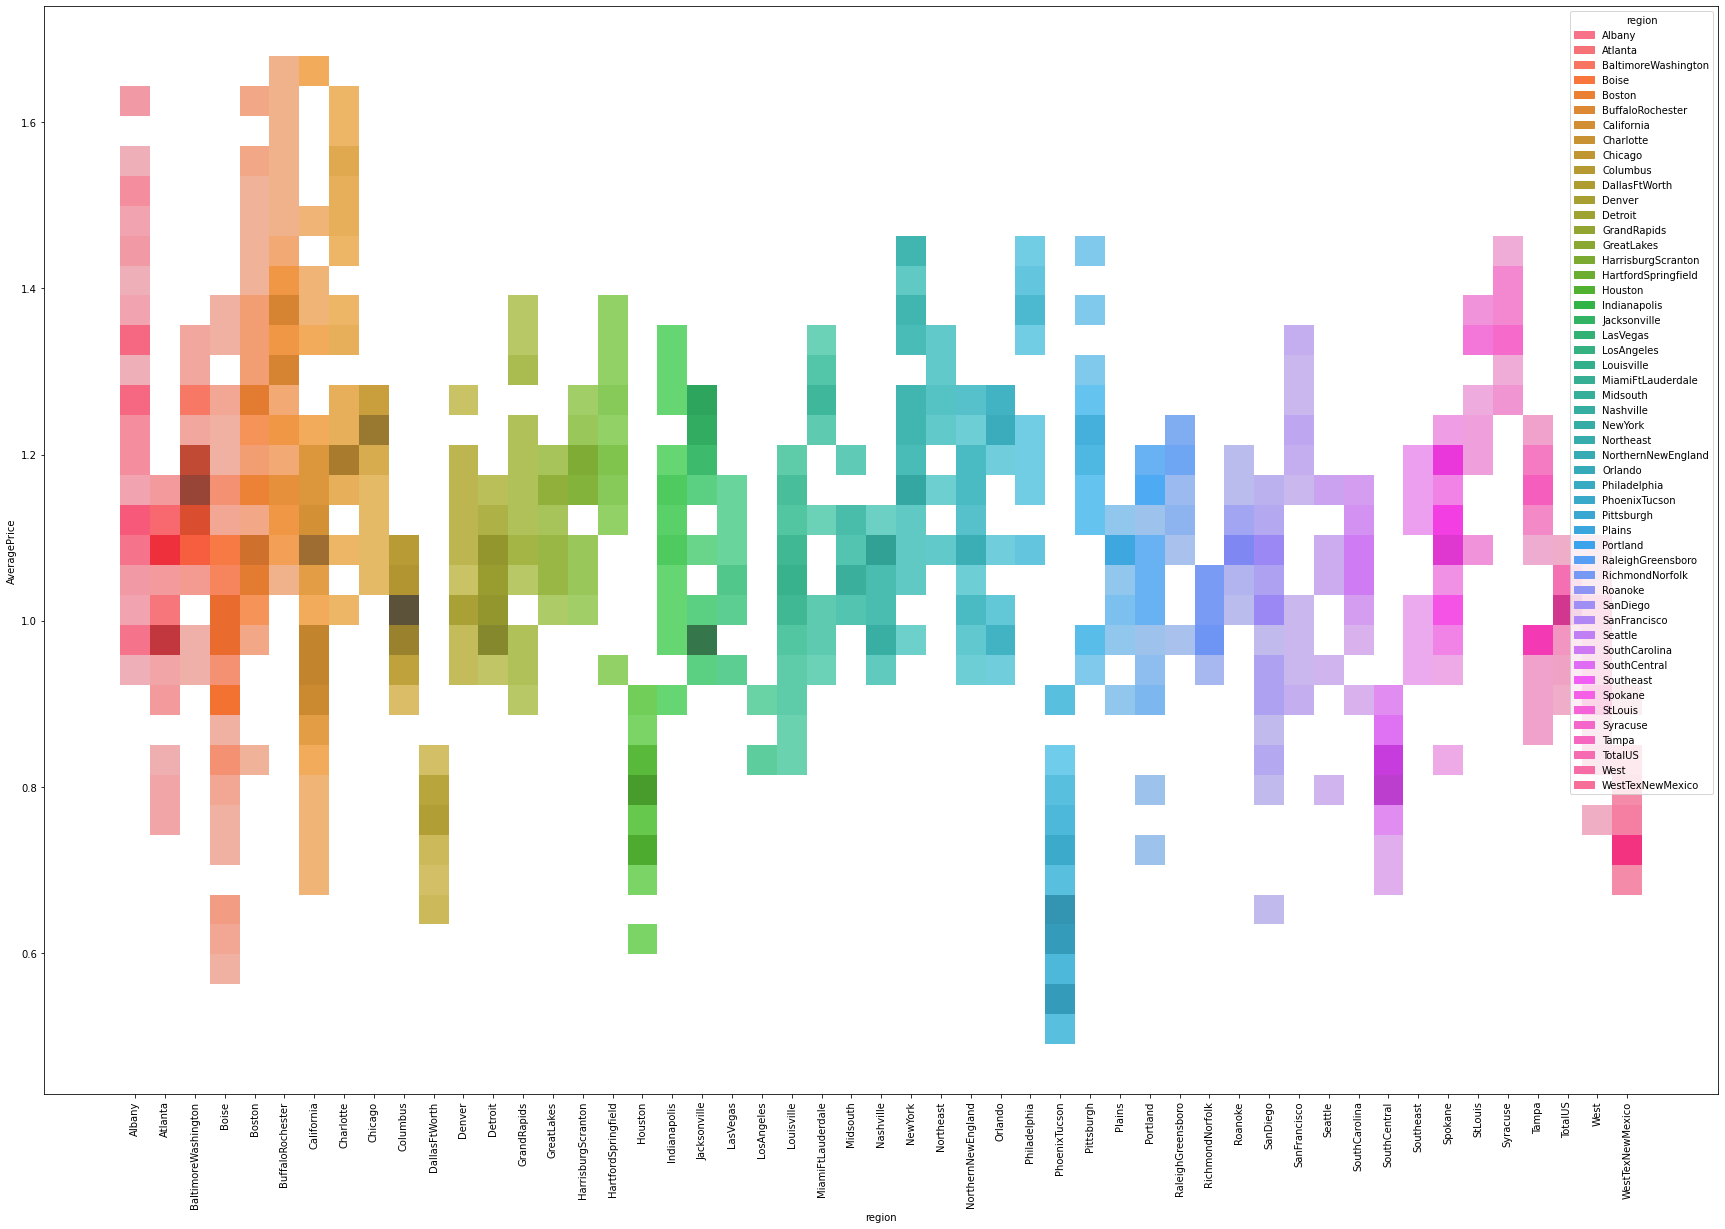

In [18]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=90)
sns.histplot(avocadoDf, x = 'region', y = 'AveragePrice', hue = 'region')

From the above we see that the AveragePrice ranges between 1.65 on the higher side and 0.5 on the lower side.

Numeric with the Target Variable

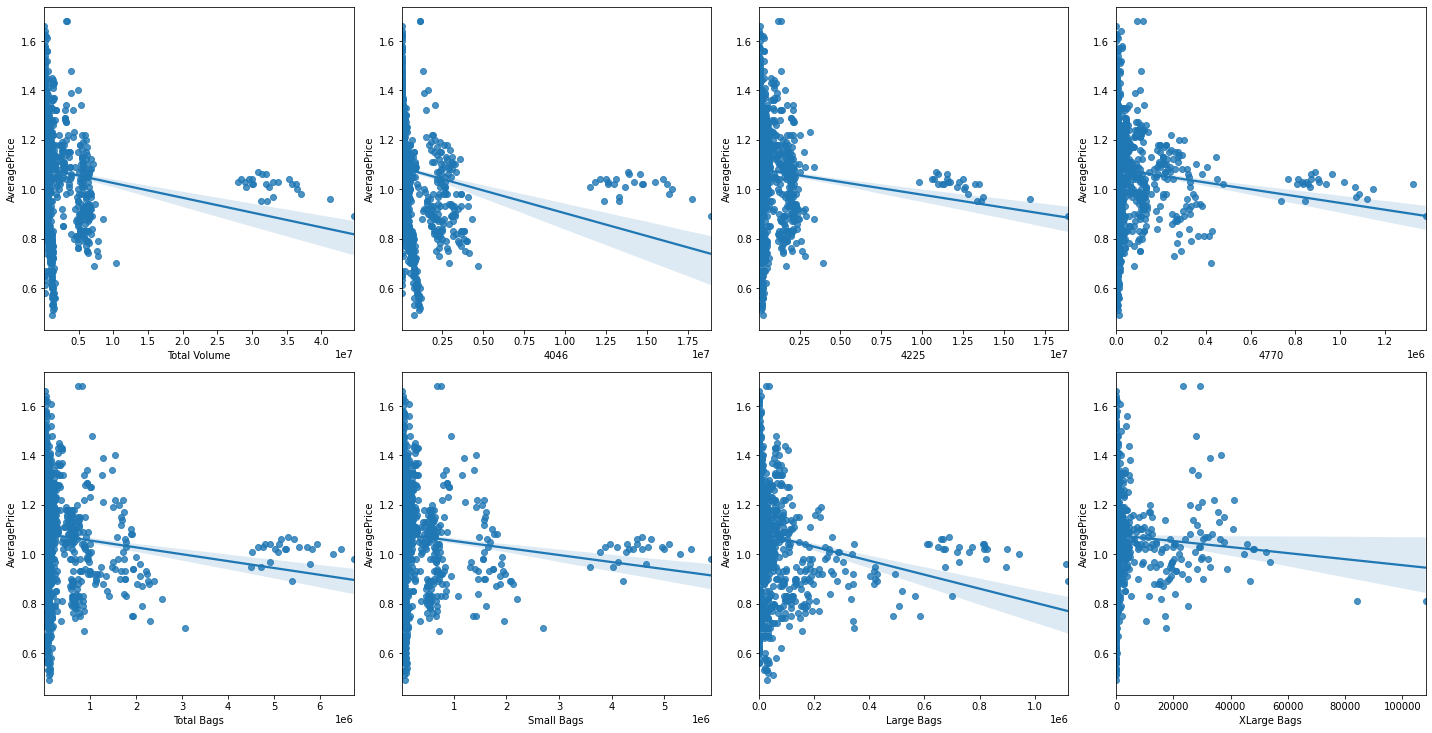

In [19]:
figure = plt.figure(figsize=(20,20))

for index in range(len(numericCols)):
    plt.subplot(4,4,index+1)
    sns.regplot(data = avocadoDf, x = avocadoDf[numericCols[index]], y = 'AveragePrice')
    plt.tight_layout()

Each of the columns in the dataset seems to be very weakly correlated with the target column with the column 'XLarge Bags' having almost flat regression line. All the columns are negatively correlated. Also, the data points seems to be concentrated on either the extreme right or to the extreme left of the graphs. This might be due to the presence of outliers. Once we handle the outliers, we will perform this visualization again.

<AxesSubplot:>

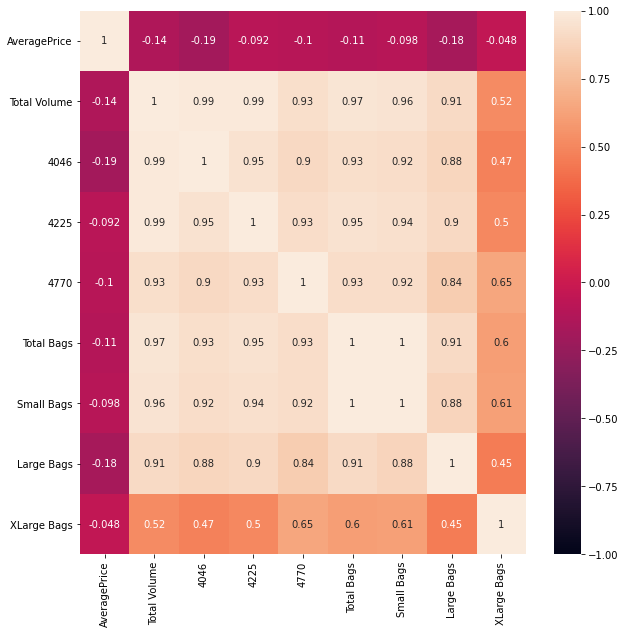

In [20]:
#Checking the Pearson Correlation Cofficient with the help of heatmap
plt.figure(figsize=(10,10))
sns.heatmap(avocadoDf.corr(), vmax = 1, vmin = -1, annot = True)

The correlation heatmap confirms are findings with the regression plots. All the columns are negatively correlated with the target variable and the columns 'XLarge Bags' and 'Small Bags' have almost zero correlation. However, let us find their statistical significance of each column in the dataset with the target column before incorporating them in our model.

In [21]:
#Making an empty list to store all columns with p-value less the 0.1
significantCols = []

#Calculating the pearson correlation cofficient and their p-values with respect to the target variable to see if they are
#statistically significant. If they are significant then we print those column's Pearson Correlation Coefficient and P-value
#and store the column names in the empty list initialised above
for index in range(len(numericCols)):
    pCoef, pVal = stats.pearsonr(avocadoDf[numericCols[index]], avocadoDf['AveragePrice'])
    if pVal < 0.1:
        significantCols.append(numericCols[index])
        print(f'{numericCols[index]}:\n\tThe Pearson Correlation Coefficient:{pCoef}\n\tP-value: {pVal}')

Total Volume:
	The Pearson Correlation Coefficient:-0.14047034697435323
	P-value: 3.9318512748552105e-08
4046:
	The Pearson Correlation Coefficient:-0.1900957942157066
	P-value: 8.263434373998012e-14
4225:
	The Pearson Correlation Coefficient:-0.09208408889635929
	P-value: 0.00032912108866282126
4770:
	The Pearson Correlation Coefficient:-0.10056651310513075
	P-value: 8.721554794476577e-05
Total Bags:
	The Pearson Correlation Coefficient:-0.11159678244293574
	P-value: 1.321108239885209e-05
Small Bags:
	The Pearson Correlation Coefficient:-0.097682010727964
	P-value: 0.00013864929355215727
Large Bags:
	The Pearson Correlation Coefficient:-0.17748019635341025
	P-value: 3.3484750478432435e-12
XLarge Bags:
	The Pearson Correlation Coefficient:-0.048283947774964926
	P-value: 0.060088637361739375


In [22]:
significantCols

['Total Volume',
 '4046',
 '4225',
 '4770',
 'Total Bags',
 'Small Bags',
 'Large Bags',
 'XLarge Bags']

We see that all the columns are statistically significant at 90% confidence interval in the dataset as all of them have a P-value of almost zero with 'XLarge Bags' being the only exception which has a P-value of 0.060.

## Preprocessing and Analysis <a name = "analysis"></a>

In [23]:
#outlier handling

In [24]:
#Making a function to detect outliers using the IQR method and then replacing them with the upper and lower bridge values
def outlierRemoverS(data, col):
    '''Note: This function is for skewed data only'''
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lowerBridge = data[col].quantile(0.25) - (1.5*IQR)
    upperBridge = data[col].quantile(0.75) + (1.5*IQR)
    if lowerBridge >=0:
            data.loc[data[col]>=upperBridge, col] = upperBridge
            data.loc[data[col]<=lowerBridge, col] = lowerBridge
    elif lowerBridge < 0:
            data.loc[data[col]>=upperBridge, col] = upperBridge
            data.loc[data[col]<=0, col] = data[col].quantile(0.5)

In [25]:
#Applying the above function on each numeric columns to handle the outliers
for index in range(len(numericCols)):
    outlierRemoverS(avocadoDf, numericCols[index])

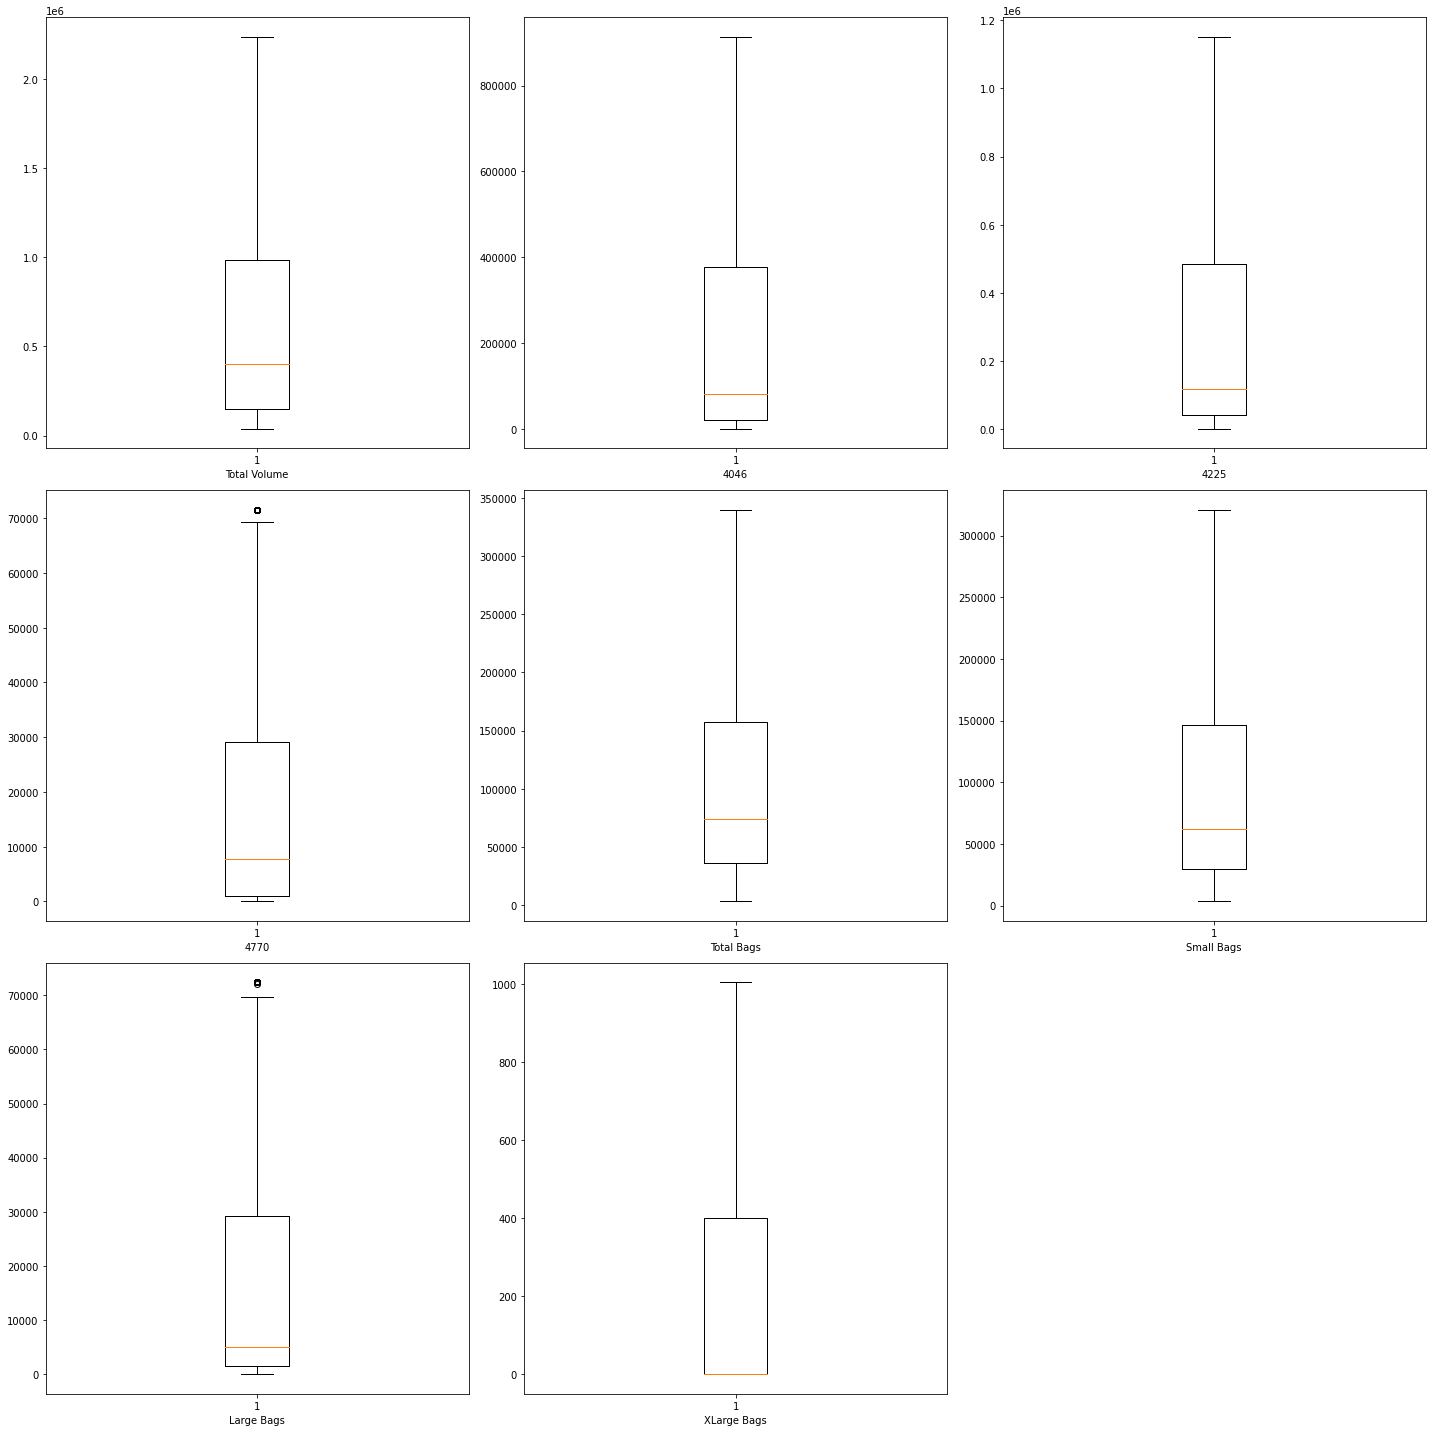

In [26]:
#Visualising after outlier removal
plt.figure(figsize=(20,20))

for index in range(len(numericCols)):
    plt.subplot(3,3,index+1)
    plt.boxplot(avocadoDf[numericCols[index]])
    plt.xlabel(numericCols[index])
    plt.tight_layout()

We see that all the outliers have been properly replaced and the dataset does not have any outliers.

In [27]:
#Checking skewness
avocadoDf[numericCols].skew()

Total Volume    1.176935
4046            1.212500
4225            1.220883
4770            1.170673
Total Bags      1.104160
Small Bags      1.166098
Large Bags      1.243415
XLarge Bags     1.178417
dtype: float64

In [28]:
#Applying various tranformation on each column to remove skewness
avocadoDf['Total Volume'] = np.log(avocadoDf['Total Volume'])
avocadoDf['4046'] = (avocadoDf['4046'])**(1/3)
avocadoDf['4225'] = np.log(avocadoDf['4225'])
avocadoDf['4770'] = (avocadoDf['4770'])**(1/3)
avocadoDf['Total Bags'] = np.log(avocadoDf['Total Bags'])
avocadoDf['Small Bags'] = np.log(avocadoDf['Small Bags'])
avocadoDf['Large Bags'] = (avocadoDf['Large Bags'])**(1/3)
avocadoDf['XLarge Bags'] = (avocadoDf['XLarge Bags'])**(1/3)

In [29]:
avocadoDf[numericCols].skew()

Total Volume    0.001860
4046            0.381440
4225           -0.202211
4770            0.273695
Total Bags     -0.244339
Small Bags     -0.100385
Large Bags      0.403290
XLarge Bags     0.769899
dtype: float64

After the column transformation, all the skewness have come within acceptable range.

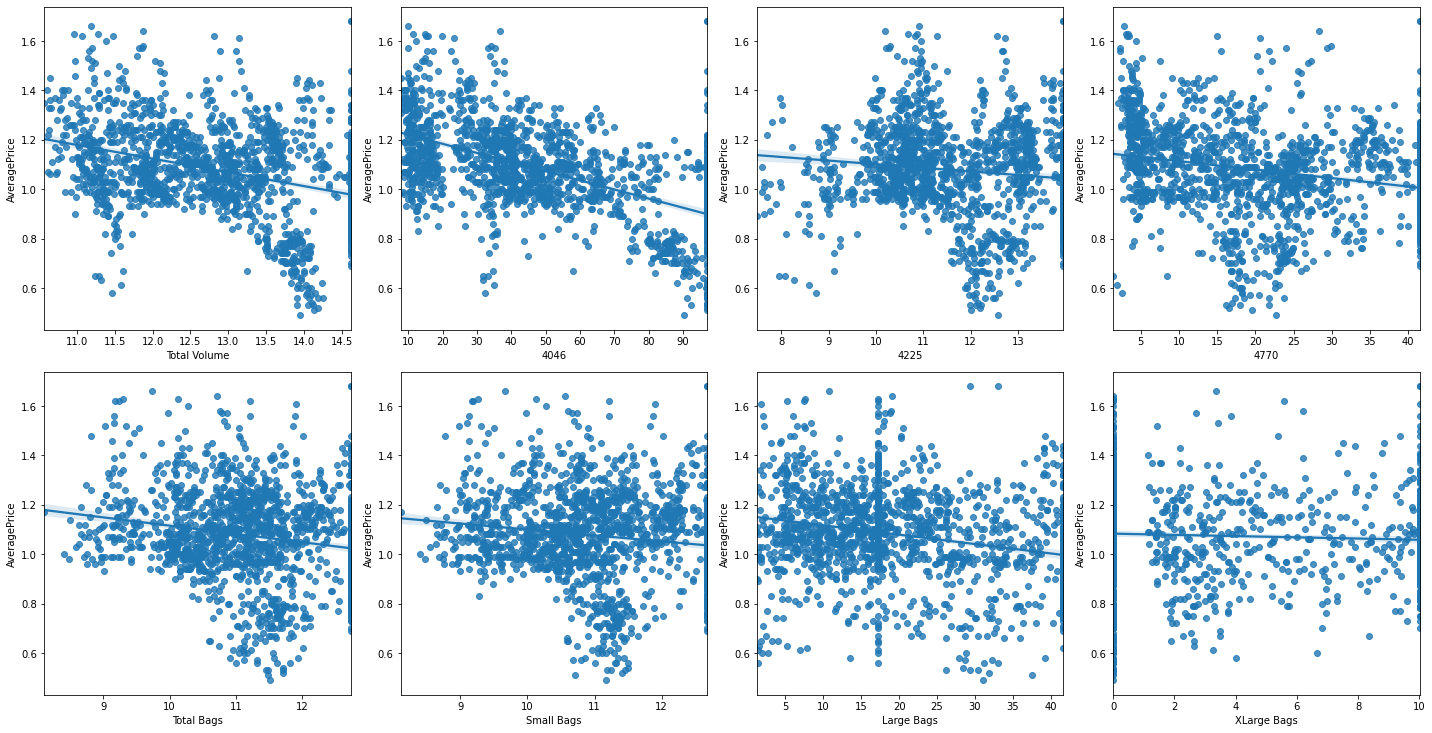

In [30]:
figure = plt.figure(figsize=(20,20))

for index in range(len(numericCols)):
    plt.subplot(4,4,index+1)
    sns.regplot(data = avocadoDf, x = avocadoDf[numericCols[index]], y = 'AveragePrice')
    plt.tight_layout()

After handling the outliers and removing skewness from the data we see that the regression plot reveals much more scattered data points as opposed to the previous regression plots which had the data points concentrated on either side of the graphs.

In [31]:
#Seperating the feature and target columns
x = avocadoDf.drop('AveragePrice', axis = 1)
y = avocadoDf.AveragePrice

In [32]:
#making a column transformer to perform standard scaling on numeric columns and one hot encoding on categorical columns
colTrans = make_column_transformer((StandardScaler(), numericCols),(OneHotEncoder(), categoricalCols), remainder='passthrough') 
x = colTrans.fit_transform(x)

In [33]:
#Finding the best random state
maxAcc = 0
maxRs = 0
for randState in range(0,200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=randState)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    predlr = lr.predict(x_test)
    acc = lr.score(x_test, y_test)*100
    if acc>maxAcc:
        maxAcc=acc
        maxRs=randState
print(f"Best accuracy is {round(maxAcc, 2)}% on Random state {randState}")

Best accuracy is 81.85% on Random state 199


In [34]:
#Splitting the x and y into train and test data with the best random state from above
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=199)

In [35]:
#Fitting various regression models to the train data and printing their perfomance metrics one-by-one
lr = LinearRegression()
rfr = RandomForestRegressor()
dtr = DecisionTreeRegressor()
svr = SVR()
knr = KNeighborsRegressor()
mlp = MLPRegressor()

models = [lr, rfr, dtr, svr, knr, mlp]

for model in models:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    #Considering models with at least 70% accuracy
    if r2_score(y_test, pred) > 0.7:
        print(f'{model}\n\tAccuracy: {model.score(x_test, y_test)}\n\tMSE: {mean_squared_error(y_test, pred)}\n\tRMSE: {mean_squared_error(y_test, pred)**(1/2)}\n\tR2 Score: {r2_score(y_test, pred)}')

LinearRegression()
	Accuracy: 0.7432497249378127
	MSE: 0.007963712539663478
	RMSE: 0.08923963547473442
	R2 Score: 0.7432497249378127
RandomForestRegressor()
	Accuracy: 0.7917595751975537
	MSE: 0.006459065649929371
	RMSE: 0.0803683124740676
	R2 Score: 0.7917595751975537
SVR()
	Accuracy: 0.7617876553347873
	MSE: 0.007388715107913741
	RMSE: 0.08595763554166518
	R2 Score: 0.7617876553347873
KNeighborsRegressor()
	Accuracy: 0.737382954092574
	MSE: 0.008145684210526315
	RMSE: 0.09025344431392253
	R2 Score: 0.737382954092574


The above are test accuracy. Lets check the train accuracy for the four models above.

In [36]:
bestModels = [lr, rfr, svr, knr]

for model in bestModels:
    model.fit(x_train, y_train)
    pred = model.predict(x_train)
    #Considering models with at least 70% accuracy
    if r2_score(y_train, pred) > 0.7:
        print(f'{model}\n\tAccuracy: {model.score(x_train, y_train)}\n\tMSE: {mean_squared_error(y_train, pred)}\n\tRMSE: {mean_squared_error(y_train, pred)**(1/2)}\n\tR2 Score: {r2_score(y_train, pred)}')

LinearRegression()
	Accuracy: 0.752832719600163
	MSE: 0.00910031680042568
	RMSE: 0.09539558061265563
	R2 Score: 0.752832719600163
RandomForestRegressor()
	Accuracy: 0.9559962886979674
	MSE: 0.0016201485592881623
	RMSE: 0.040251069045283284
	R2 Score: 0.9559962886979674
SVR()
	Accuracy: 0.7982687935765056
	MSE: 0.007427430863891467
	RMSE: 0.08618254384671797
	R2 Score: 0.7982687935765056
KNeighborsRegressor()
	Accuracy: 0.8470300890749785
	MSE: 0.005632115416323166
	RMSE: 0.07504742111707215
	R2 Score: 0.8470300890749785


By observing the test and train R2 scores of the four models we see that LinearRegression and SVR have the least difference between the test and train scores. This indicates that these algorithms where able to generalise the data well enough to produce consistent results even on unseen data. Therefore we will select these two algorithms and perform hyper parameter tuning on them. The model which will have the higher score after hyper parameter tuning will be chosen as the final model.

## Hyperparameter Tuning and Model Saving<a name = "hyperparam"></a>

In [37]:
#Linear Regression Hyperparameter tuning
lrParameters = {'fit_intercept': [True, False],
             'normalize': [True, False]}

In [38]:
lrGS = GridSearchCV(lr, param_grid = lrParameters, cv = 5, scoring = 'r2', n_jobs = -1)

In [39]:
lrGS.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='r2')

In [40]:
lrGS.best_params_

{'fit_intercept': True, 'normalize': False}

In [41]:
lr = LinearRegression(fit_intercept = True, normalize = False)

lr.fit(x_train, y_train)

predTr = lr.predict(x_train)
predT = lr.predict(x_test)

print(f'Training R2 Score after hyperparameter tuning: {r2_score(y_train, predTr)}\nTest R2 Score after hyperparameter tuning: {r2_score(y_test, predT)}')

Training R2 Score after hyperparameter tuning: 0.752832719600163
Test R2 Score after hyperparameter tuning: 0.7432497249378127


In [42]:
#SVR Hyperparameter Tuning
parameterSVR = {'kernel': ['linear', 'poly', 'rbf'],
               'gamma': ['scale', 'auto'],
               'C': [1, 0.1, 0.001, 0.0001]}

In [43]:
svrGS = GridSearchCV(svr, param_grid = parameterSVR, cv = 5, scoring = 'r2', n_jobs = -1)

In [44]:
svrGS.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 0.1, 0.001, 0.0001],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='r2')

In [45]:
svrGS.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [46]:
svr = SVR(C=1, gamma = 'scale', kernel = 'rbf')

svr.fit(x_train, y_train)

predTr = svr.predict(x_train)
predT = svr.predict(x_test)

print(f'Training R2 Score after hyperparameter tuning: {r2_score(y_train, predTr)}\nTest R2 Score after hyperparameter tuning: {r2_score(y_test, predT)}')

Training R2 Score after hyperparameter tuning: 0.7982687935765056
Test R2 Score after hyperparameter tuning: 0.7617876553347873


From the above hyper parameter tuning of the two models, we see that SVR has a higher test and train R2 scores then LinearRegression and therefore we will choose this as the final model.

In [47]:
#Saving
import joblib

joblib.dump(svr, 'avocado.pkl')

#Testing

model = joblib.load('avocado.pkl')
model.predict(x_test)

array([1.19275598, 1.05138369, 1.14506031, 1.22345681, 1.01130002,
       1.08637401, 1.19904258, 1.12367145, 1.39560177, 0.74253866,
       1.16152698, 0.91081093, 1.20791315, 0.93824813, 1.42793871,
       0.81915194, 1.1804169 , 1.08318552, 1.16098412, 1.0176221 ,
       0.79194865, 1.15524192, 0.94078209, 1.30715234, 0.97000063,
       1.22212077, 1.27568827, 1.34655136, 1.08541782, 0.91081093,
       1.28039483, 1.23996915, 1.14414693, 1.15592756, 1.08961551,
       0.73148491, 1.13898873, 1.04921023, 1.10686552, 0.62955513,
       1.1447503 , 1.03244612, 1.11473738, 1.02686368, 0.97000063,
       1.0563921 , 1.30753912, 1.06712356, 0.7948067 , 0.9950215 ,
       1.17977796, 1.20338955, 1.1222352 , 1.11431537, 1.14489121,
       0.94224647, 1.25115547, 1.02827902, 1.20688816, 1.18695453,
       1.08278767, 0.94981288, 1.05206172, 0.97000063, 0.77962466,
       1.03022913, 1.18023669, 1.06422838, 1.30471615, 0.5990508 ,
       1.25737929, 1.12803519, 1.13816721, 1.31146835, 1.01036